In [1]:
%load_ext autoreload
%autoreload 2
from pybaseball import statcast, pitching_stats
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from matplotlib import patches
%matplotlib inline

# use Statcast data (from 2015-2018) so we can get spin rate, etc.
train_data_dates = [('2015-04-05', '2015-10-04'),      # 2015 data
                    ('2016-04-03', '2016-10-02'),       # 2016 data
                    ('2017-04-02', '2017-10-01'),       # 2017 data
                    ('2018-03-29', '2018-10-01')]       # 2018 data

### Get the Outcome Style Data (Groundball/flyball rates, strike percentages, whiff rates, etc.)

In [2]:
# scrape the data from baseball savant
#pitcher_season_stats = pitching_stats(2018)
pitcher_season_stats = pd.read_csv("/Users/chrisjackson/sports/baseball/data/overall_data_2018.csv")

# select the features that we want to use to categorize the pitchers... questions we want to answer:
#   - are they strike throwers?
#   - do they allow a lot of baserunners? 
#   - groundball or flyball pitcher?
#   - are they swing and miss guys (inside and outside of the zone)?
cols_to_keep = ['Name', 'Strikes', 'Pitches', 
                'K/9', 'BB/9',  'H/9', 'HR/9',
                'GB/FB', 'LD%', 'GB%', 
                'O-Swing%', 'Z-Swing%', 'Swing%', 
                'O-Contact%', 'Z-Contact%', 'Contact%', 
                'Zone%', 'F-Strike%', 'SwStr%']
pitcher_season_stats = pitcher_season_stats[cols_to_keep]

# keep only pitchers with at least 500 pitches in a season... try to weed out the noise, but keep short relievers
pitcher_season_stats = pitcher_season_stats[pitcher_season_stats['Pitches'] >= 500]

# compute the percentage of pitches that are strikes
pitcher_season_stats['Strike Pct'] = pitcher_season_stats['Strikes'] / pitcher_season_stats['Pitches']
pitcher_season_stats.drop(['Strikes', 'Pitches'], axis=1, inplace=True)

# use the GB/FB ratio to compute the OF flyball pct
pitcher_season_stats['Flyball%'] = (pitcher_season_stats['GB%'] / pitcher_season_stats['GB/FB'])

# drop the GB/FB ratio
pitcher_season_stats.drop(['GB/FB'], axis=1, inplace=True)

# rename the Name column so we can merge on it later... and the hit ball types to make them more readable
pitcher_season_stats.rename(columns={'Name': 'player_name',
                                     'GB%': 'Groundball%',
                                     'LD%': 'Linedrive%'}, inplace=True)

# reorder the columns
pitcher_season_stats = pitcher_season_stats[[
    'player_name', 'Strike Pct', 'K/9', 'BB/9', 'H/9', 'HR/9', 
    'Linedrive%', 'Groundball%', 'Flyball%', 
    'O-Swing%', 'Z-Swing%', 'Swing%', 
    'O-Contact%', 'Z-Contact%', 'Contact%', 
    'Zone%', 'F-Strike%', 'SwStr%', 
       ]]

print(f"Number of features: {pitcher_season_stats.shape[1]-1}")
pitcher_season_stats.head()

Number of features: 17


,player_name,Strike Pct,K/9,BB/9,H/9,HR/9,Linedrive%,Groundball%,Flyball%,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%
0,Jacob deGrom,0.688979,11.16,1.91,6.30,0.41,0.219,0.464,0.315646,0.379,0.688,0.517,0.577,0.797,0.708,0.446,0.665,0.151
1,Max Scherzer,0.688806,12.24,2.08,6.12,0.94,0.181,0.343,0.476389,0.358,0.701,0.520,0.539,0.775,0.690,0.474,0.657,0.162
2,Justin Verlander,0.689816,12.20,1.56,6.56,1.18,0.195,0.291,0.510526,0.346,0.688,0.509,0.575,0.794,0.716,0.477,0.689,0.145
3,Chris Sale,0.678812,13.50,1.94,5.81,0.63,0.196,0.442,0.362295,0.364,0.628,0.480,0.545,0.765,0.672,0.441,0.676,0.158
4,Gerrit Cole,0.673319,12.40,2.88,6.42,0.85,0.213,0.360,0.428571,0.321,0.688,0.494,0.552,0.800,0.715,0.471,0.635,0.141


### Get the Descriptive Statistics for Each Column

In [3]:
pitcher_season_stats.describe()

,Strike Pct,K/9,BB/9,H/9,HR/9,Linedrive%,Groundball%,Flyball%,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%
count,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000
mean,0.636091,8.623766,3.381064,8.485830,1.135745,0.214149,0.431909,0.353891,0.308017,0.674832,0.466138,0.624434,0.852804,0.765938,0.430543,0.600532,0.109296
std,0.027136,2.025516,1.161295,1.647865,0.517337,0.033967,0.083724,0.081524,0.033996,0.039066,0.030911,0.080374,0.040706,0.050025,0.032538,0.047357,0.025135
min,0.555897,3.620000,0.770000,3.750000,0.000000,0.115000,0.192000,0.108148,0.193000,0.556000,0.386000,0.396000,0.687000,0.608000,0.325000,0.444000,0.040000
25%,0.617157,7.240000,2.622500,7.410000,0.790000,0.194000,0.374250,0.303027,0.286000,0.649000,0.445250,0.571000,0.829000,0.732500,0.409000,0.571250,0.092000
50%,0.636105,8.515000,3.215000,8.395000,1.080000,0.212000,0.437500,0.349370,0.305000,0.675000,0.464000,0.633000,0.854500,0.771000,0.432000,0.603000,0.106000
75%,0.655285,9.967500,4.010000,9.420000,1.437500,0.233000,0.481000,0.403024,0.328750,0.701000,0.486000,0.681000,0.881000,0.801000,0.451000,0.631000,0.126000
max,0.721281,16.310000,8.250000,14.180000,3.200000,0.394000,0.730000,0.600000,0.428000,0.794000,0.578000,0.824000,0.956000,0.913000,0.514000,0.753000,0.192000


### Get the Pitch-by-Pitch Data

In [4]:
# get the data from baseball savant
#pitch_by_pitch_data = statcast(start_dt='2018-03-29', end_dt='2018-10-01')
pitch_by_pitch_data = pd.read_csv("/Users/chrisjackson/sports/baseball/data/pitch_data_2018.csv")

# choose the columns we want to use for identifying Families
cols_to_keep = ['pitcher', 'player_name', 'p_throws', 'pitch_type', 
                'release_speed', 'release_pos_x', 'release_pos_z', 'release_spin_rate', 
                'pfx_x', 'pfx_z'] #, 'plate_x', 'plate_z']
pitch_by_pitch_data = pitch_by_pitch_data[cols_to_keep]

# make sure pitcher ID's are ints
pitch_by_pitch_data['pitcher'] = pitch_by_pitch_data['pitcher'].astype(int)

pitch_by_pitch_data.head()

,pitcher,player_name,p_throws,pitch_type,release_speed,release_pos_x,release_pos_z,release_spin_rate,pfx_x,pfx_z
0,445276,Kenley Jansen,R,FC,92.2,-1.9690,6.2644,2629.0,0.3852,1.3383
1,445276,Kenley Jansen,R,FC,93.0,-1.7689,6.2976,2686.0,0.5206,1.2567
2,445276,Kenley Jansen,R,FC,91.6,-1.7451,6.2154,2581.0,0.6363,1.1421
3,445276,Kenley Jansen,R,FF,93.1,-1.4250,6.1929,2243.0,-0.4317,1.3971
4,445276,Kenley Jansen,R,FC,91.4,-1.9144,6.2641,2658.0,0.5592,1.1846


### Categorize Pitches as Fastball, Breaking Pitch or Off-Speed Pitch 

In [5]:
# group the various pitch types into three types (fastball=FB, breaking=BR and off-speed=OS)
fastball_pitches = ['FC', 'FF', 'FA', 'FT', 'SI']
breaking_pitches = ['CU', 'KC', 'KN', 'SC', 'SL', 'GY']
offspeed_pitches = ['CH', 'EP', 'FO', 'FS']

# pitches to drop (pitch outs, intentional balls, uncategorized)
dropped_pitches = ['AB', 'AS', 'IN', 'NP', 'PO', 'UN']

# categorize pitches
def categorize_pitches(x):
    if x in fastball_pitches:
        return 'FB'
    elif x in breaking_pitches:
        return 'BR'
    elif x in offspeed_pitches:
        return 'OS'
    else:
        return x
pitch_by_pitch_data['pitch_type'] = pitch_by_pitch_data['pitch_type'].apply(categorize_pitches)

# drop any rows with non-pitch pitches
pitch_by_pitch_data = pitch_by_pitch_data[~pitch_by_pitch_data['pitch_type'].isin(dropped_pitches)]

# drop any rows with NaN for pitch type
pitch_by_pitch_data = pitch_by_pitch_data[pd.notnull(pitch_by_pitch_data['pitch_type'])]

# print out the breakdown of categorized pitch types
pitch_counts = Counter(pitch_by_pitch_data['pitch_type'])
print(pitch_counts)
print()
pitch_by_pitch_data.head()

Counter({'FB': 433506, 'BR': 198670, 'OS': 86205})



,pitcher,player_name,p_throws,pitch_type,release_speed,release_pos_x,release_pos_z,release_spin_rate,pfx_x,pfx_z
0,445276,Kenley Jansen,R,FB,92.2,-1.9690,6.2644,2629.0,0.3852,1.3383
1,445276,Kenley Jansen,R,FB,93.0,-1.7689,6.2976,2686.0,0.5206,1.2567
2,445276,Kenley Jansen,R,FB,91.6,-1.7451,6.2154,2581.0,0.6363,1.1421
3,445276,Kenley Jansen,R,FB,93.1,-1.4250,6.1929,2243.0,-0.4317,1.3971
4,445276,Kenley Jansen,R,FB,91.4,-1.9144,6.2641,2658.0,0.5592,1.1846


### Compute Average Speed, Movement, Spin Rate and Location for Each Pitch Type (FB, BR and OS)

In [6]:
# build a list of pitcher IDs
pitcher_list = list(set(pitch_by_pitch_data['pitcher'].tolist()))
print(f"{len(pitcher_list)} pitchers in the data.")

# initiate a dataframe to hold the data
pitcher_pitch_avgs_df = pd.DataFrame()

# loop thru pitchers in the list and construct their personal DF
for pitcher in pitcher_list:
    
    # select pitches thrown by pitcher
    pitcher_df = pitch_by_pitch_data[pitch_by_pitch_data['pitcher'] == pitcher]
    total_num_pitches = len(pitcher_df)

    # loop thru the pitch types
    pitch_types = ['FB', 'BR', 'OS']
    pitch_type_avgs = []
    for pitch_type in pitch_types:

        # select the pitches thrown by pitcher by type
        pitcher_pitch_df = pitcher_df[pitcher_df['pitch_type'] == pitch_type]
        num_pitches = len(pitcher_pitch_df)

        # groupby player name/throws/pitch_type and compute mean of remaining features
        pitcher_pitch_df = pd.DataFrame(pitcher_pitch_df.groupby(['pitcher', 'player_name', 'p_throws', 'pitch_type']).mean())
        
        # rename columns to have pitch type in name
        pitcher_pitch_df.columns = [pitch_type + ' ' + x for x in pitcher_pitch_df.columns.tolist()]

        pitcher_pitch_df.reset_index(inplace=True, drop=False)
        
        # compute the percentage of pitches thrown that are of pitch_type
        pitcher_pitch_df[pitch_type+'%'] = num_pitches / total_num_pitches

        pitcher_pitch_df.drop('pitch_type', axis=1, inplace=True)

        pitcher_pitch_df.set_index(['pitcher', 'player_name', 'p_throws'], inplace=True)

        # append pitch type dataframe to pitcher's dataframe
        pitch_type_avgs.append(pitcher_pitch_df)

    # append pitcher's dataframe to all-pitchers dataframe
    pitcher_pitch_avgs_df = pitcher_pitch_avgs_df.append(pd.concat(pitch_type_avgs, axis=1, join='inner'))

pitcher_pitch_avgs_df.reset_index(inplace=True, drop=False)

pitcher_pitch_avgs_df.head()

798 pitchers in the data.


,pitcher,player_name,p_throws,FB release_speed,FB release_pos_x,FB release_pos_z,FB release_spin_rate,FB pfx_x,FB pfx_z,FB%,BR release_speed,BR release_pos_x,BR release_pos_z,BR release_spin_rate,BR pfx_x,BR pfx_z,BR%,OS release_speed,OS release_pos_x,OS release_pos_z,OS release_spin_rate,OS pfx_x,OS pfx_z,OS%
0,622608.0,Antonio Senzatela,R,93.620961,-2.285924,5.945654,2087.743354,-0.365652,0.984344,0.640052,81.452758,-2.314456,6.026409,2186.284091,0.614134,-0.245062,0.272906,86.635338,-2.488155,5.849395,2121.796992,-0.764528,0.745999,0.087042
1,596001.0,Jakob Junis,R,91.015995,-2.317984,5.567430,2006.536682,-0.808441,0.922652,0.533122,81.737478,-2.333335,5.658151,2456.332757,1.204074,-0.278207,0.408034,84.741916,-2.263286,5.687574,1488.401198,-0.754883,0.410291,0.058844
2,493603.0,Adam Ottavino,R,92.559733,-2.630619,5.449220,2338.377676,-0.764796,0.559525,0.529504,81.380336,-3.023986,5.346797,2787.326565,1.364027,0.039236,0.468135,88.233333,-2.762600,5.329200,1794.333333,-0.826567,0.332467,0.002360
3,593958.0,Eduardo Rodriguez,L,91.985239,1.793006,5.653759,2210.555085,0.685681,1.007188,0.714656,83.564072,1.796171,5.717142,2204.468750,-0.217843,0.386618,0.072201,87.415822,1.771342,5.703651,2074.484787,1.509818,0.425179,0.213143
4,452657.0,Jon Lester,L,89.987012,2.846886,5.631914,2269.320034,0.411403,1.113000,0.750402,74.771575,2.862379,5.787039,2570.905930,-0.993078,-0.445862,0.157285,84.949826,2.824643,5.674921,1804.641115,1.164385,0.470043,0.092313


### convert release position x, z coordinates into an "arm slot angle" (measured from vertical)

In [7]:
pitcher_pitch_avgs_df['FB arm_angle'] = np.abs((180 / 3.14) * np.arctan(pitcher_pitch_avgs_df['FB release_pos_x'] / pitcher_pitch_avgs_df['FB release_pos_z']))
pitcher_pitch_avgs_df['BR arm_angle'] = np.abs((180 / 3.14) * np.arctan(pitcher_pitch_avgs_df['BR release_pos_x'] / pitcher_pitch_avgs_df['BR release_pos_z']))
pitcher_pitch_avgs_df['OS arm_angle'] = np.abs((180 / 3.14) * np.arctan(pitcher_pitch_avgs_df['OS release_pos_x'] / pitcher_pitch_avgs_df['OS release_pos_z']))
pitcher_pitch_avgs_df.drop(['FB release_pos_x', 'FB release_pos_z', 'BR release_pos_x', 'BR release_pos_z', 'OS release_pos_x', 'OS release_pos_z'], axis=1, inplace=True)

pitcher_pitch_avgs_df.head()

,pitcher,player_name,p_throws,FB release_speed,FB release_spin_rate,FB pfx_x,FB pfx_z,FB%,BR release_speed,BR release_spin_rate,BR pfx_x,BR pfx_z,BR%,OS release_speed,OS release_spin_rate,OS pfx_x,OS pfx_z,OS%,FB arm_angle,BR arm_angle,OS arm_angle
0,622608.0,Antonio Senzatela,R,93.620961,2087.743354,-0.365652,0.984344,0.640052,81.452758,2186.284091,0.614134,-0.245062,0.272906,86.635338,2121.796992,-0.764528,0.745999,0.087042,21.040905,21.020051,23.055116
1,596001.0,Jakob Junis,R,91.015995,2006.536682,-0.808441,0.922652,0.533122,81.737478,2456.332757,1.204074,-0.278207,0.408034,84.741916,1488.401198,-0.754883,0.410291,0.058844,22.615733,22.421867,21.710353
2,493603.0,Adam Ottavino,R,92.559733,2338.377676,-0.764796,0.559525,0.529504,81.380336,2787.326565,1.364027,0.039236,0.468135,88.233333,1794.333333,-0.826567,0.332467,0.002360,25.782068,29.506140,27.415637
3,593958.0,Eduardo Rodriguez,L,91.985239,2210.555085,0.685681,1.007188,0.714656,83.564072,2204.468750,-0.217843,0.386618,0.072201,87.415822,2074.484787,1.509818,0.425179,0.213143,17.604580,17.450154,17.261602
4,452657.0,Jon Lester,L,89.987012,2269.320034,0.411403,1.113000,0.750402,74.771575,2570.905930,-0.993078,-0.445862,0.157285,84.949826,1804.641115,1.164385,0.470043,0.092313,26.829823,26.331217,26.474852


### Compute the Percent Difference Between OS and FB Speeds

In [8]:
pitcher_pitch_avgs_df['OS_FB_Diff'] = (pitcher_pitch_avgs_df['OS release_speed'] - pitcher_pitch_avgs_df['FB release_speed']) / (pitcher_pitch_avgs_df['FB release_speed'])

pitcher_pitch_avgs_df.head()

,pitcher,player_name,p_throws,FB release_speed,FB release_spin_rate,FB pfx_x,FB pfx_z,FB%,BR release_speed,BR release_spin_rate,BR pfx_x,BR pfx_z,BR%,OS release_speed,OS release_spin_rate,OS pfx_x,OS pfx_z,OS%,FB arm_angle,BR arm_angle,OS arm_angle,OS_FB_Diff
0,622608.0,Antonio Senzatela,R,93.620961,2087.743354,-0.365652,0.984344,0.640052,81.452758,2186.284091,0.614134,-0.245062,0.272906,86.635338,2121.796992,-0.764528,0.745999,0.087042,21.040905,21.020051,23.055116,-0.074616
1,596001.0,Jakob Junis,R,91.015995,2006.536682,-0.808441,0.922652,0.533122,81.737478,2456.332757,1.204074,-0.278207,0.408034,84.741916,1488.401198,-0.754883,0.410291,0.058844,22.615733,22.421867,21.710353,-0.068934
2,493603.0,Adam Ottavino,R,92.559733,2338.377676,-0.764796,0.559525,0.529504,81.380336,2787.326565,1.364027,0.039236,0.468135,88.233333,1794.333333,-0.826567,0.332467,0.002360,25.782068,29.506140,27.415637,-0.046742
3,593958.0,Eduardo Rodriguez,L,91.985239,2210.555085,0.685681,1.007188,0.714656,83.564072,2204.468750,-0.217843,0.386618,0.072201,87.415822,2074.484787,1.509818,0.425179,0.213143,17.604580,17.450154,17.261602,-0.049676
4,452657.0,Jon Lester,L,89.987012,2269.320034,0.411403,1.113000,0.750402,74.771575,2570.905930,-0.993078,-0.445862,0.157285,84.949826,1804.641115,1.164385,0.470043,0.092313,26.829823,26.331217,26.474852,-0.055977


### Merge the Outcome Style Data with the Pitch Characteristic Data

In [9]:
pitcher_data = pd.merge(pitcher_pitch_avgs_df, pitcher_season_stats, how='inner', on='player_name')

print(f"Shape of the final training data: {pitcher_data.shape}")
pitcher_data.head()

Shape of the final training data: (417, 39)


,pitcher,player_name,p_throws,FB release_speed,FB release_spin_rate,FB pfx_x,FB pfx_z,FB%,BR release_speed,BR release_spin_rate,BR pfx_x,BR pfx_z,BR%,OS release_speed,OS release_spin_rate,OS pfx_x,OS pfx_z,OS%,FB arm_angle,BR arm_angle,OS arm_angle,OS_FB_Diff,Strike Pct,K/9,BB/9,H/9,HR/9,Linedrive%,Groundball%,Flyball%,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%
0,622608.0,Antonio Senzatela,R,93.620961,2087.743354,-0.365652,0.984344,0.640052,81.452758,2186.284091,0.614134,-0.245062,0.272906,86.635338,2121.796992,-0.764528,0.745999,0.087042,21.040905,21.020051,23.055116,-0.074616,0.621321,6.87,2.99,9.37,1.00,0.211,0.463,0.326056,0.247,0.665,0.427,0.670,0.868,0.803,0.431,0.613,0.084
1,596001.0,Jakob Junis,R,91.015995,2006.536682,-0.808441,0.922652,0.533122,81.737478,2456.332757,1.204074,-0.278207,0.408034,84.741916,1488.401198,-0.754883,0.410291,0.058844,22.615733,22.421867,21.710353,-0.068934,0.647287,8.34,2.19,9.25,1.63,0.209,0.420,0.371681,0.318,0.640,0.464,0.617,0.903,0.796,0.454,0.627,0.095
2,493603.0,Adam Ottavino,R,92.559733,2338.377676,-0.764796,0.559525,0.529504,81.380336,2787.326565,1.364027,0.039236,0.468135,88.233333,1794.333333,-0.826567,0.332467,0.002360,25.782068,29.506140,27.415637,-0.046742,0.630503,12.98,4.17,4.75,0.58,0.185,0.430,0.383929,0.261,0.556,0.391,0.495,0.804,0.688,0.440,0.602,0.122
3,593958.0,Eduardo Rodriguez,L,91.985239,2210.555085,0.685681,1.007188,0.714656,83.564072,2204.468750,-0.217843,0.386618,0.072201,87.415822,2074.484787,1.509818,0.425179,0.213143,17.604580,17.450154,17.261602,-0.049676,0.627324,10.13,3.12,8.26,1.11,0.201,0.387,0.411702,0.316,0.710,0.474,0.629,0.857,0.766,0.400,0.615,0.111
4,452657.0,Jon Lester,L,89.987012,2269.320034,0.411403,1.113000,0.750402,74.771575,2570.905930,-0.993078,-0.445862,0.157285,84.949826,1804.641115,1.164385,0.470043,0.092313,26.829823,26.331217,26.474852,-0.055977,0.615187,7.38,3.17,8.62,1.19,0.258,0.377,0.362500,0.272,0.680,0.438,0.678,0.879,0.805,0.406,0.574,0.085


### Split Into Two Groups: Lefties and Righties

In [10]:
lh_pitcher_data = pitcher_data[pitcher_data['p_throws'] == 'L']
print(f"Number of LH pitchers: {lh_pitcher_data.shape[0]}")

rh_pitcher_data = pitcher_data[pitcher_data['p_throws'] == 'R']
print(f"Number of RH pitchers: {rh_pitcher_data.shape[0]}")

Number of LH pitchers: 111
Number of RH pitchers: 306


## Rescaling, PCA and Clustering 

### Helper functions: Rescale the Data, Perform PCA and Find Number of Dimensions to Explain 98% of the Variance, Plot the clusters, etc.

In [93]:
# custom scatter plot function which allows for markers to take a list
def mscatter(x,y, ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    ax = ax or plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

# perform k-means clustering and use the Gap Statistic to find optimal k
def optimalK(data, nrefs=3, maxClusters=10):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):

            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)

            # Fit to it
            km = KMeans(k, n_jobs=-1)
            km.fit(randomReference)

            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)

        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap

        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal



def perform_pca_clustering(data):

    data.reset_index(inplace=True, drop=True)

    # keep pitcher ID and name
    data_ID_name = data[['pitcher', 'player_name']]

    # data for clustering
    data_clustering = data.drop(['pitcher', 'player_name', 'p_throws'], axis=1)
    print(f"Number of original dimensions: {data_clustering.shape[1]}")

    # rescale 
    scaler = MinMaxScaler()
    data_clustering_scaled = pd.DataFrame(scaler.fit_transform(data_clustering))

    # find the minimal number of dimensions that captures 98% of the variance
    # fitting the PCA algorithm with our Data
    pca = PCA().fit(data_clustering_scaled)

    # the cumulative explained variance
    exp_var_ratio = list(np.cumsum(pca.explained_variance_ratio_))

    # use the number of dimensions that get us to 98% explained variance
    exp_var_threshold = 0.98
    for i, ev in enumerate(exp_var_ratio):
        if ev > exp_var_threshold:
            num_components = i
            break
        else:
            num_components = len(data_clustering_scaled.columns)

    print(f"{num_components} are required to explain 98% of the variance.")
    
    # perform PCA with computed number of dimensions
    pca = PCA(n_components=num_components)
    data_clustering_pca = pd.DataFrame(pca.fit_transform(data_clustering_scaled))

    # find the optimal k
    k, _ = optimalK(data_clustering_pca)
    print(f"Optimal k: {k}")

    # perform K-Means clustering with computed number of clusters
    kmeans = KMeans(n_clusters=k)
    kmeans.fit_transform(data_clustering_pca)
    labels = pd.DataFrame(kmeans.labels_)
    labels.rename(columns={0: 'Cluster_Number'}, inplace=True)

    # put the original data back together with a new column for the cluster number label
    pitchers_clusters = pd.concat([data_ID_name, labels, data_clustering], axis=1, join='inner')
    
    # re-do the analysis for visualization purposes
    # perform PCA with only 2dimensions
    pca = PCA(n_components=2)
    data_clustering_pca = pd.DataFrame(pca.fit_transform(data_clustering_scaled))

    kmeans = KMeans(n_clusters=k).fit(data_clustering_pca)

    labels = kmeans.labels_
    # map cluster number to marker 
    marker_map = {0: 'o', 1: 'v', 2: '^', 3: '>', 4: '<', 5: '8', 6: 's', 7: 'p',
                  8: 'P', 9: '*', 10: 'D', 11: 'X', 12: 'h', 13: 'H'}
    labels = [marker_map[x] for x in labels]

    data_clustering_pca['cluster_number'] = kmeans.predict(data_clustering_pca)

    data_clustering_pca['cluster_number'] = data_clustering_pca['cluster_number'].apply(lambda x: marker_map[x])
    
    data_cluster_w_name = pd.merge(data_ID_name, data_clustering_pca, left_index=True, right_index=True)
    print(data_cluster_w_name.head())
    
    jon_lester_x = data_cluster_w_name[data_cluster_w_name['player_name'] == 'Jon Lester'][0].tolist()
    jon_lester_y = data_cluster_w_name[data_cluster_w_name['player_name'] == 'Jon Lester'][1].tolist()
    
    aroldis_chapman_x = data_cluster_w_name[data_cluster_w_name['player_name'] == 'Aroldis Chapman'][0].tolist()
    aroldis_chapman_y = data_cluster_w_name[data_cluster_w_name['player_name'] == 'Aroldis Chapman'][1].tolist()
    
    clayton_kershaw_x = data_cluster_w_name[data_cluster_w_name['player_name'] == 'Clayton Kershaw'][0].tolist()
    clayton_kershaw_y = data_cluster_w_name[data_cluster_w_name['player_name'] == 'Clayton Kershaw'][1].tolist()
    
    dallas_keuchel_x = data_cluster_w_name[data_cluster_w_name['player_name'] == 'Dallas Keuchel'][0].tolist()
    dallas_keuchel_y = data_cluster_w_name[data_cluster_w_name['player_name'] == 'Dallas Keuchel'][1].tolist()
    
    gio_gonzalez_x = data_cluster_w_name[data_cluster_w_name['player_name'] == 'Chris Sale'][0].tolist()
    gio_gonzalez_y = data_cluster_w_name[data_cluster_w_name['player_name'] == 'Chris Sale'][1].tolist()
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.plot()
    ax.plot(jon_lester_x, jon_lester_y, c='k', marker='X')
    ax.text(jon_lester_x[0], jon_lester_y[0]+0.05, 'Jon Lester')
    ax.plot(aroldis_chapman_x, aroldis_chapman_y, c='k', marker='X')
    ax.text(aroldis_chapman_x[0], aroldis_chapman_y[0]+0.05, 'Aroldis Chapman')
    ax.plot(clayton_kershaw_x, clayton_kershaw_y, c='k', marker='X')
    ax.text(clayton_kershaw_x[0], clayton_kershaw_y[0]+0.05, 'Clayton Kershaw')
    ax.plot(dallas_keuchel_x, dallas_keuchel_y, c='k', marker='X')
    ax.text(dallas_keuchel_x[0], dallas_keuchel_y[0]+0.05, 'Dallas Keuchel')
    ax.plot(gio_gonzalez_x, gio_gonzalez_y, c='k', marker='X')
    ax.text(gio_gonzalez_x[0], gio_gonzalez_y[0]+0.05, 'Chris Sale')
    ax2 = mscatter(data_clustering_pca.iloc[:, 0], data_clustering_pca.iloc[:, 1], ax=ax, m=labels, c=kmeans.labels_, s=80)
#    ax2 = plt.scatter(data_clustering_pca.iloc[:, 0], data_clustering_pca.iloc[:, 1], c=kmeans.labels_, s=80)
#    plt.legend(loc='best')
    
    return k, pitchers_clusters, ax2

### Analysis for Lefties

Number of original dimensions: 36
21 are required to explain 98% of the variance.
Optimal k: 8
    pitcher        player_name         0         1 cluster_number
0  593958.0  Eduardo Rodriguez  0.235281  0.053493              o
1  452657.0         Jon Lester -0.303671  0.011025              <
2  593974.0      Wandy Peralta -0.121911 -0.008086              p
3  606273.0       Roenis Elias -0.162420 -0.320734              p
4  608331.0          Max Fried  0.172475 -0.667350              >


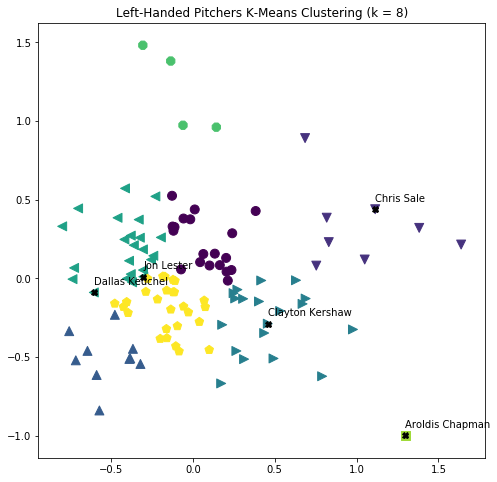

In [94]:
lh_k, lh_pitchers_clusters, ax = perform_pca_clustering(lh_pitcher_data)
plt.title(f"Left-Handed Pitchers K-Means Clustering (k = {lh_k})")
plt.show()

In [92]:
lh_pitchers_clusters[lh_pitchers_clusters['Cluster_Number'] == 4]

,pitcher,player_name,Cluster_Number,FB release_speed,FB release_spin_rate,FB pfx_x,FB pfx_z,FB%,BR release_speed,BR release_spin_rate,BR pfx_x,BR pfx_z,BR%,OS release_speed,OS release_spin_rate,OS pfx_x,OS pfx_z,OS%,FB arm_angle,BR arm_angle,OS arm_angle,OS_FB_Diff,Strike Pct,K/9,BB/9,H/9,HR/9,Linedrive%,Groundball%,Flyball%,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%
22,543045.0,Adam Conley,4,95.210455,2260.888636,1.405940,1.063930,0.568475,88.131200,2163.680000,-0.056394,0.587296,0.161499,85.770813,2041.000000,1.425165,0.747391,0.270026,30.331776,30.762216,29.500602,-0.099145,0.633075,8.88,3.20,6.57,0.89,0.198,0.443,0.360163,0.339,0.742,0.507,0.529,0.829,0.712,0.416,0.624,0.146
26,571760.0,Andrew Heaney,4,91.921473,2466.906367,1.167441,1.214445,0.581699,78.593237,2383.377713,-0.412711,-0.280939,0.252360,83.317287,1931.242888,1.376011,0.629770,0.165940,31.782464,29.936950,30.186813,-0.093604,0.661706,9.00,2.25,8.55,1.35,0.237,0.412,0.352137,0.335,0.679,0.482,0.610,0.851,0.755,0.427,0.652,0.118
32,571901.0,Aaron Loup,4,90.370447,2286.103270,1.310997,0.309971,0.818565,75.930882,2671.911765,-1.487059,-0.546540,0.095640,79.650820,1970.770492,1.500859,-0.123752,0.085795,45.730494,47.030551,48.239926,-0.118619,0.656863,9.98,3.18,10.89,0.91,0.225,0.492,0.282759,0.328,0.616,0.455,0.618,0.835,0.748,0.441,0.607,0.115
40,453265.0,Tony Watson,4,92.467078,2302.166667,1.323981,0.734233,0.507307,84.045109,2331.203297,-0.270207,0.272625,0.192067,85.478472,2383.902778,1.631944,0.667819,0.300626,33.851615,33.934621,34.476174,-0.075579,0.688217,9.82,1.91,7.36,0.55,0.231,0.432,0.337500,0.361,0.688,0.514,0.658,0.806,0.751,0.468,0.686,0.128
50,621381.0,Matt Strahm,4,93.422107,2399.166090,1.088922,1.189487,0.580160,82.996377,2689.832714,-0.799806,-0.045027,0.276553,85.973427,2153.601399,1.471507,0.341931,0.143287,24.754233,21.349557,25.651307,-0.079731,0.664329,10.13,3.08,5.72,0.88,0.215,0.349,0.436250,0.300,0.674,0.477,0.563,0.821,0.735,0.473,0.665,0.126
78,519242.0,Chris Sale,4,94.846569,2330.125817,1.285492,0.864539,0.484945,79.695986,2495.832569,-1.210086,-0.352185,0.345483,86.996028,2045.343458,1.604227,0.018026,0.169572,32.313706,32.501003,34.622182,-0.082771,0.678812,13.50,1.94,5.81,0.63,0.196,0.442,0.362295,0.364,0.628,0.480,0.545,0.765,0.672,0.441,0.676,0.158
100,573124.0,Taylor Rogers,4,93.449900,2061.303393,1.361338,0.718331,0.529039,79.854545,2713.194175,-1.199999,-0.124695,0.464625,89.150000,1881.166667,1.494067,0.143750,0.006336,17.950772,18.154933,19.424954,-0.046013,0.673077,9.88,2.11,6.45,0.40,0.256,0.445,0.298658,0.321,0.595,0.451,0.524,0.878,0.746,0.475,0.642,0.114


### Analysis for Righties 

In [ ]:
rh_k, rh_pitchers_clusters, ax = perform_pca_clustering(rh_pitcher_data)
plt.title(f"Right-Handed Pitchers K-Means Clustering (k = {rh_k})")
plt.show()

In [ ]:
rh_pitchers_clusters.head()

## Qualitative Analysis of the Clusters

### Left-Handed Pitchers

In [95]:
def get_group_box_plot(df, k, feat_name):
    feat_list = []
    for i in range(k):
        k_df = df[df['Cluster_Number'] == i]
        feat = k_df[feat_name].tolist()
        feat_list.append(feat)
    feat_avg = df[feat_name].mean()
    feat_std = df[feat_name].std()

    plt.boxplot(feat_list)
    plt.plot([1, k+1], [feat_avg+feat_std, feat_avg+feat_std], 'k--')
    plt.plot([1, k+1], [feat_avg, feat_avg], 'k--')
    plt.plot([1, k+1], [feat_avg-feat_std, feat_avg-feat_std], 'k--')
    plt.title(feat_name)
    plt.xlabel('Cluster Number')
    plt.show()

#### Feature Distributions for Each Cluster

The horizontal dashed lines represent the mean for all left-handers (and the 1 sigma bounds)

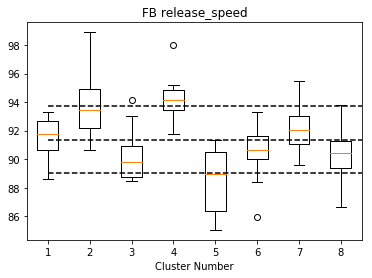

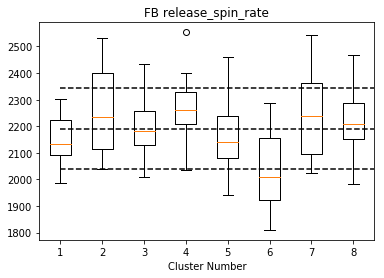

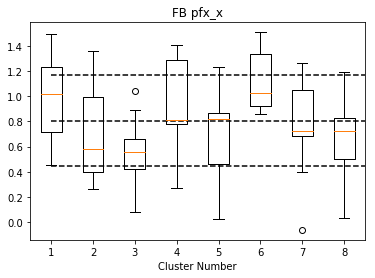

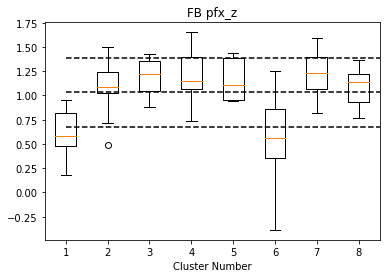

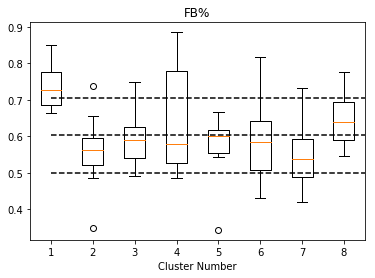

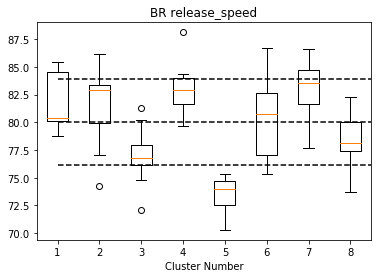

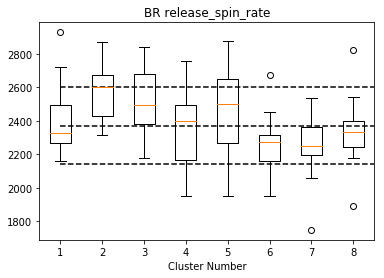

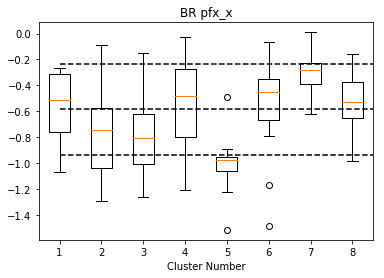

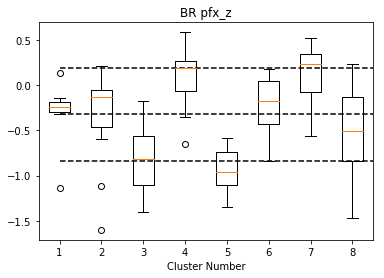

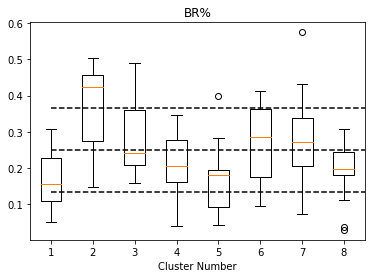

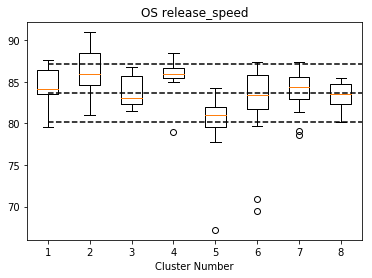

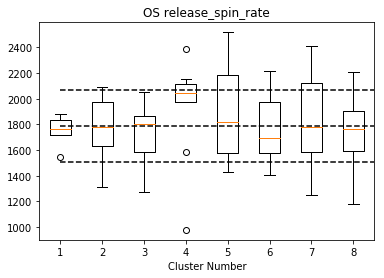

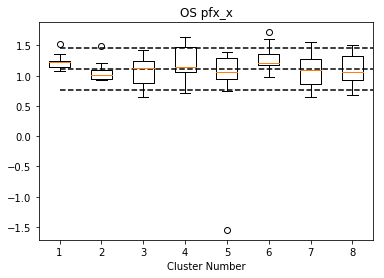

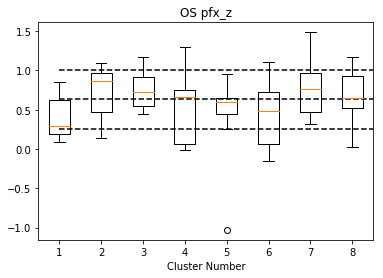

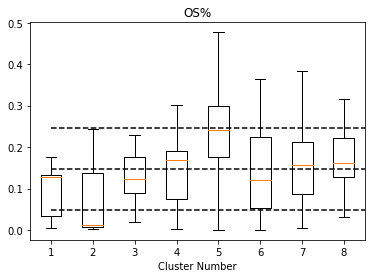

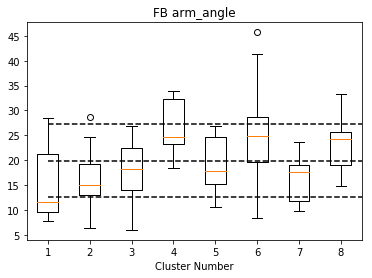

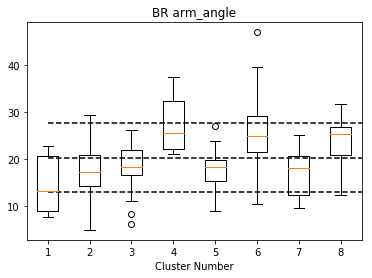

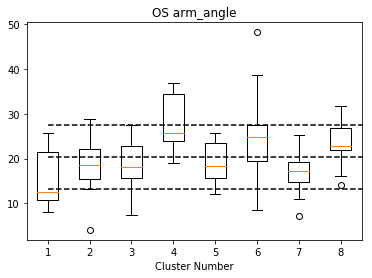

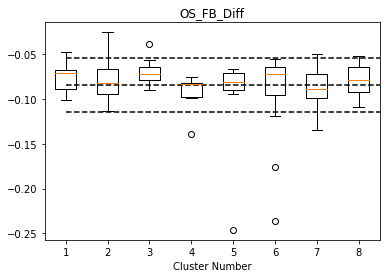

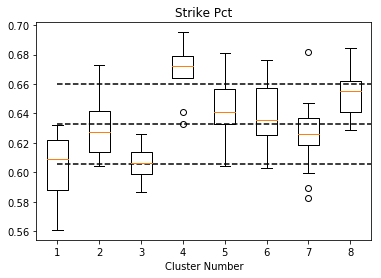

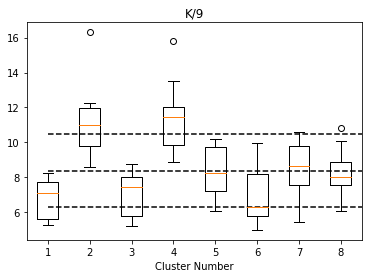

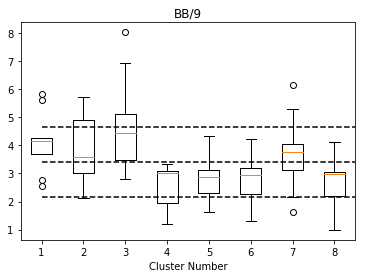

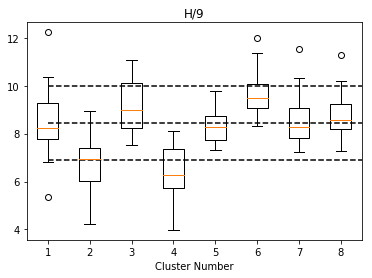

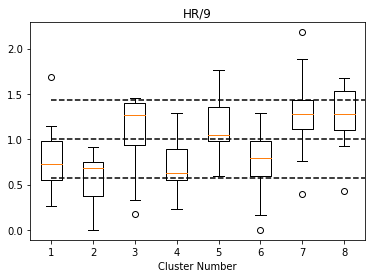

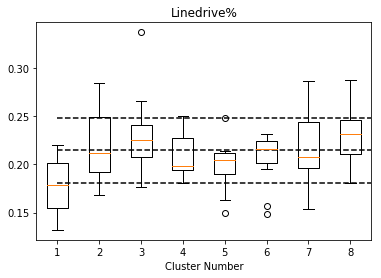

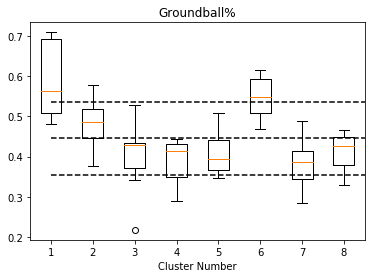

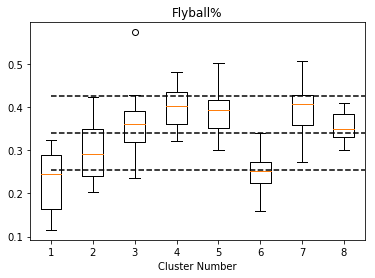

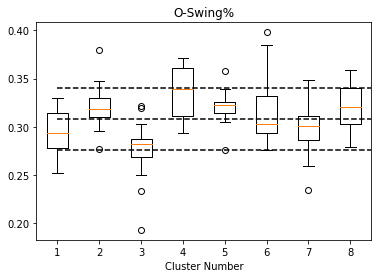

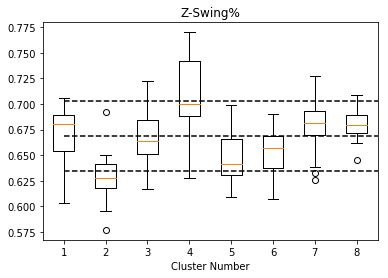

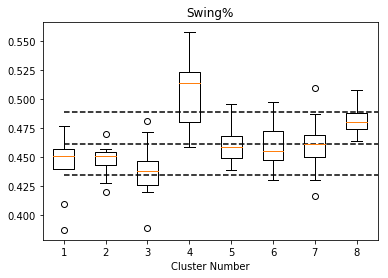

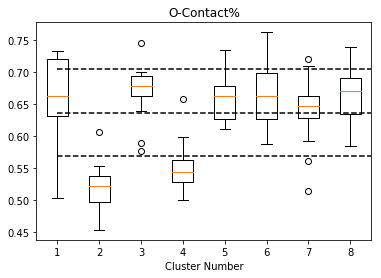

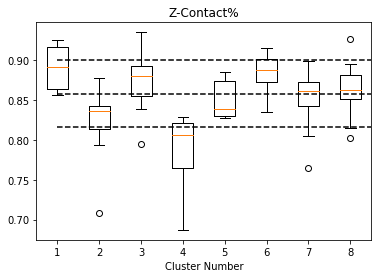

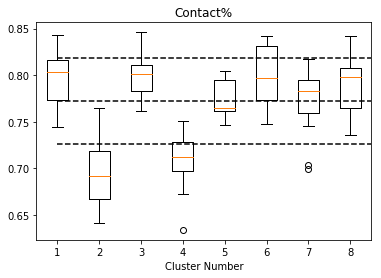

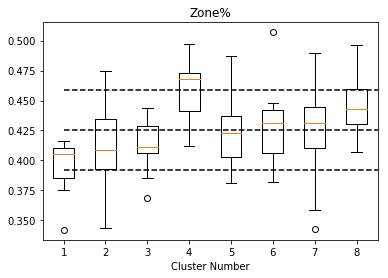

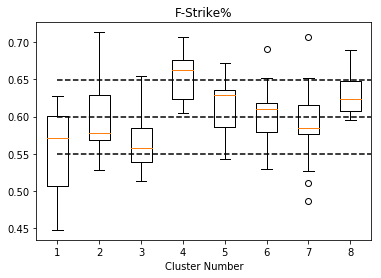

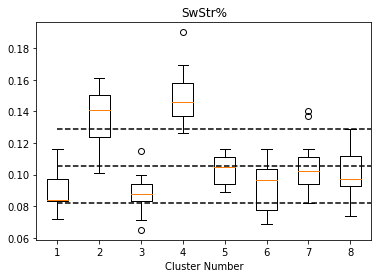

In [96]:
for col in lh_pitchers_clusters.columns.tolist()[3:]:
    get_group_box_plot(lh_pitchers_clusters, lh_k, col)

#### Looks like Cluster 12 is Made up of Hard-Throwing Swing & Miss guys

In [ ]:
lh_pitchers_clusters[lh_pitchers_clusters['Cluster_Number'] == 11]

### Right-Handed Pitchers

In [ ]:
for col in rh_pitchers_clusters.columns.tolist()[3:]:
    get_group_box_plot(rh_pitchers_clusters, rh_k, col)

In [ ]:
rh_pitchers_clusters[rh_pitchers_clusters['Cluster_Number'] == 10]

In [ ]:
pitch_by_pitch_data = statcast()

In [ ]:
pitch_by_pitch_data.head()

In [ ]:
pitch_by_pitch_data.description.unique()